## Fitting IPCC AR6 sea level projections

In [ ]:
"""
:Project:   boston-tides
:Created:   Tue Oct 19 16:14:49 2021
:Filename:  ar6_fit_distribution.ipynb

Finds best-fit distribution for IPCC AR6 sea level rise projections for Boston.
"""
__version__ = "2.0"
__author__ = "Perry Oddo <perry.oddo@nasa.gov>"

In [2]:
import netCDF4
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.stats import lognorm, beta, cauchy, gaussian_kde
from fitter import Fitter, get_common_distributions, get_distributions

random.seed(10)
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)

In [3]:
# Read in IPCC AR6 projections: Boston tide gauge - SSP5.85 Low Confidence
ipcc = netCDF4.Dataset("data/total_ssp585_low_confidence_values.nc")
print(ipcc.variables.keys())

# Find indices for specified quantiles
quant_inds = [7,20,53,86,99]

# Check
print(ipcc.variables["quantiles"][quant_inds].data)

# Find year index for 2100
years = ipcc.variables["years"]
print(years[8].data)

# Extract SLR projections
slr = ipcc.variables["sea_level_change"][:,:,0]
slr = slr/1000 # convert to meters

dict_keys(['locations', 'lat', 'lon', 'years', 'quantiles', 'sea_level_change'])
[0.05 0.17 0.5  0.83 0.95]
2100


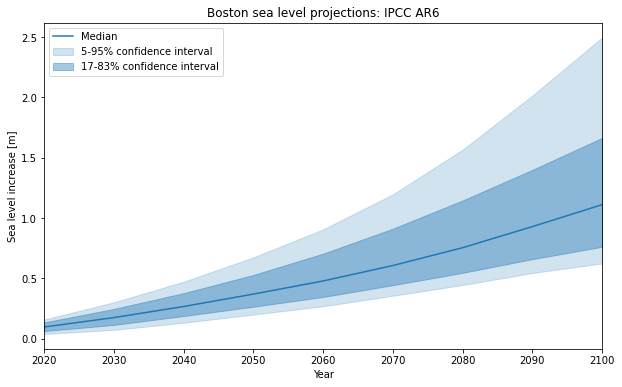

In [4]:
# Plot projected SLR in 2100
plt.figure()
plt.fill_between(years[0:9], slr[quant_inds[0], 0:9], slr[quant_inds[4], 0:9], alpha=0.2, color='C0',label='5-95% confidence interval')
plt.fill_between(years[0:9], slr[quant_inds[1], 0:9], slr[quant_inds[3], 0:9], alpha=0.4, color='C0',label='17-83% confidence interval')
plt.plot(years[0:9], slr[quant_inds[2], 0:9], color='C0',label='Median')
plt.xlim([years[0], years[8]])
plt.xlabel("Year")
plt.ylabel('Sea level increase [m]')
plt.title("Boston sea level projections: IPCC AR6")
plt.legend(loc="upper left")
#plt.savefig("plots/fit_dist/1_ar6_projections.png")
plt.show()

[0.623 0.761 1.111 1.665 2.498]


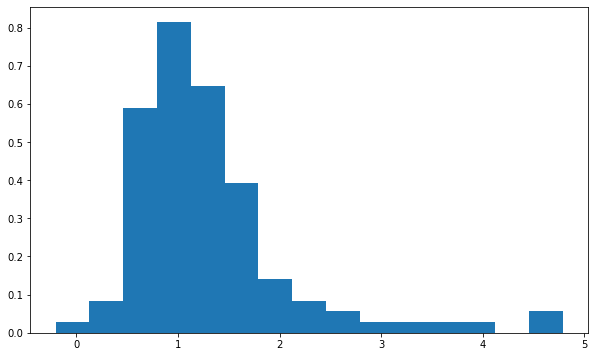

In [5]:
# Isolate SLR values at 2100
slr_2100_ar6 = slr[:, 8]

# Print quantiles
print(slr_2100_ar6[quant_inds])

# Plot histogram
plt.hist(slr_2100_ar6, density=True, bins=15)
plt.show()

None
         sumsquare_error        aic         bic  kl_div
lognorm         0.081331  87.143520 -754.461166     inf
cauchy          0.095498  85.897380 -741.952422     inf
gamma           0.124374  88.076471 -709.011913     inf
beta            0.141710  86.705663 -690.376486     inf
norm            0.320540  95.961238 -612.385992     inf
Best fit: {'lognorm': (0.34995597818118684, -0.6962996821715732, 1.8700161129358817)}


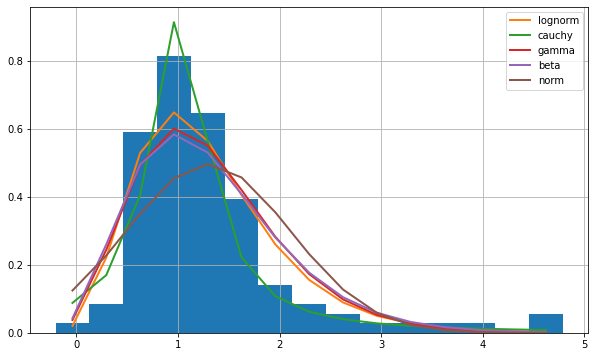

In [6]:
# Fit values to common distributions
fit = Fitter(slr_2100_ar6, bins=15, density=True,
             distributions=["gamma",
                            "lognorm",
                            "beta", 
                            "norm", 
                            "cauchy",
                            "uniform"])
print(fit.fit())
print(fit.summary())
#plt.savefig("plots/fit_dist/2_fit_distributions.png")

# Identify best fit method
print("Best fit:", fit.get_best(method = "sumsquare_error"))

In [7]:
# Find parameters for best fit
best_fit_params = fit.fitted_param["lognorm"]
print(best_fit_params)

# Save to file
with open("outputs/lognorm_params.pkl", "wb") as _:
    pickle.dump(best_fit_params, _)

(0.34995597818118684, -0.6962996821715732, 1.8700161129358817)


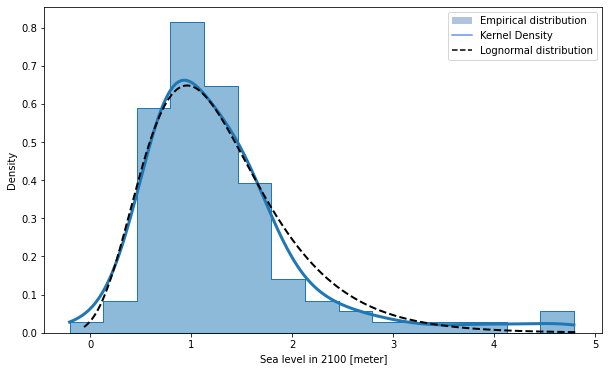

In [8]:
# Display probability density function for lognorm fit
xs = np.linspace(lognorm.ppf(0.001, best_fit_params[0],best_fit_params[1],best_fit_params[2]),
                 lognorm.ppf(0.999, best_fit_params[0],best_fit_params[1],best_fit_params[2]), 1000)
rv = lognorm(best_fit_params[0],best_fit_params[1],best_fit_params[2])

# Plot alongside empirical distribution
sns.histplot(slr_2100_ar6, kde=True, bins=15, stat="density", element="step",
             line_kws={"color": "dark blue","lw": 3})
plt.plot(xs, rv.pdf(xs), "--", color="black", lw=2)
plt.xlabel("Sea level in 2100 [meter]")
legend_elements = [
    Patch(facecolor="lightsteelblue", label="Empirical distribution"),
    Line2D([0],[0], color="cornflowerblue", label="Kernel Density"),
    Line2D([0], [0], linestyle="dashed", color="black", label="Lognormal distribution")
]

plt.legend(handles=legend_elements)
#plt.savefig("plots/fit_dist/3_lognorm_fit.png")
plt.show()

In [9]:
# Plot cumulative distribution function
emp_kde = sns.kdeplot(slr_2100_ar6).get_lines()[0].get_data()[0]
lognorm_kde = np.linspace(lognorm.ppf(0.001, best_fit_params[0],best_fit_params[1],best_fit_params[2]),
                          lognorm.ppf(0.999, best_fit_params[0],best_fit_params[1],best_fit_params[2]), 200)

df_1 = pd.DataFrame(data=emp_kde, columns=["Sea level"])
df_1["Distribution"] = "Empirical"

df_2 = pd.DataFrame(data=lognorm_kde, columns=["Sea level"])
df_2["Distribution"] = "Lognormal"

df_3 = pd.concat([df_1, df_2], ignore_index=True)
plt.close()

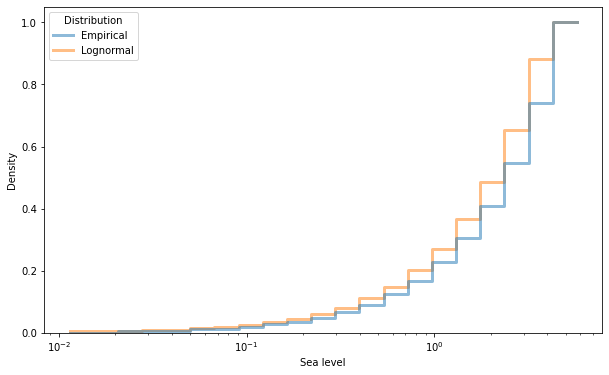

In [10]:
sns.histplot(
    data=df_3, x="Sea level", hue="Distribution", alpha=0.5,
    linewidth=3, log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,
)
#plt.savefig("plots/fit_dist/4_distribution_cdf.png")
plt.show()

In [11]:
# Save upper and lower bounds
bounds = (np.min(slr_2100_ar6), np.max(slr_2100_ar6))

# Save bounds and distribution to file
with open("outputs/slr_bounds_ar6.pkl", "wb") as _:
    pickle.dump(bounds, _)
    
with open("outputs/slr_2100_ar6.pkl", "wb") as _:
    pickle.dump(slr_2100_ar6, _)